# BERT for Multi-Class Text Classification

For this project I used BERT to try to classify BBC news articles by subject. The data comes from a Kaglle challenge, found at https://www.kaggle.com/competitions/learn-ai-bbc. 

In [63]:
#pip install tensorflow_text

In [22]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import preprocessing

I save the URL's for the BERT preprocessor and encoder.

In [2]:
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
train = pd.read_csv('/content/gdrive/Othercomputers/My Laptop/Python/BBC News Train.csv')
test = pd.read_csv('/content/gdrive/Othercomputers/My Laptop/Python/BBC News Test.csv')

In [5]:
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


Taking a look at the data, we can see that each article consists of text along with a label. The different subjects are roughly balanced, so it will not be necessary to balance them.

In [6]:
train['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

With the data downloaded, I set up the training set. The labels will need to be transofrmed into integers and reshaped. 

In [7]:
x_train = train['Text']
y_train = train['Category']

In [8]:
y_train[:10]

0         business
1         business
2         business
3             tech
4         business
5         politics
6            sport
7    entertainment
8         business
9    entertainment
Name: Category, dtype: object

In [9]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

In [10]:
y_train[:10]

array([0, 0, 0, 4, 0, 2, 3, 1, 0, 1])

In [23]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))

In [11]:
# make the BERT layers
bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

Now it is time to build the model. I use the Keras functional API, feed the text into the BERT layers for preprocessing and embedding, then use a dropout layer as recommended at https://www.tensorflow.org/text/tutorials/classify_text_with_bert. Finally there is a dense layer that uses a softmax activation to assign each observation to one of the five subject categories. 

In [50]:
# Now use a keras functional API
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# neural network layers
x = tf.keras.layers.Dropout(0.1, name = 'dropout')(outputs['pooled_output'])
x = tf.keras.layers.Dense(5, activation = 'softmax', name = 'output')(x)

#construct final model
model = tf.keras.Model(inputs = [text_input], outputs = [x])

In [51]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

I now compile the model and train it for 50 epochs. Some experimentation showed that the loss continues diminishing even up to the 50th epoch, but gains are increasingly incremental.

In [52]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [53]:
model.fit(x_train,y_train, epochs = 50)

Epoch 1/50
47/47 [==============================] - 18s 341ms/step - loss: 1.5463 - accuracy: 0.3268
Epoch 2/50
47/47 [==============================] - 17s 355ms/step - loss: 1.2761 - accuracy: 0.5221
Epoch 3/50
47/47 [==============================] - 17s 354ms/step - loss: 1.1155 - accuracy: 0.5879
Epoch 4/50
47/47 [==============================] - 16s 344ms/step - loss: 1.0079 - accuracy: 0.6698
Epoch 5/50
47/47 [==============================] - 16s 340ms/step - loss: 0.9211 - accuracy: 0.7047
Epoch 6/50
47/47 [==============================] - 16s 343ms/step - loss: 0.8343 - accuracy: 0.7745
Epoch 7/50
47/47 [==============================] - 16s 347ms/step - loss: 0.7609 - accuracy: 0.7899
Epoch 8/50
47/47 [==============================] - 16s 348ms/step - loss: 0.7153 - accuracy: 0.8235
Epoch 9/50
47/47 [==============================] - 19s 399ms/step - loss: 0.6695 - accuracy: 0.8309
Epoch 10/50
47/47 [==============================] - 16s 343ms/step - loss: 0.6281 - accura

With the model trained, let's generate predictions for the test set. The test set does not include labels, as it is from a Kaggle competition.

In [54]:
test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [55]:
x_test = test['Text']

In [56]:
preds = model.predict(x_test)

23/23 [==============================] - 9s 345ms/step


In [57]:
preds

array([[8.42925012e-02, 1.18338251e-02, 4.92211096e-02, 8.51861119e-01,
        2.79145548e-03],
       [1.13271335e-02, 3.30536952e-03, 1.91084691e-03, 3.73705960e-04,
        9.83082891e-01],
       [2.87585706e-03, 3.41762975e-03, 3.68772587e-03, 9.88798082e-01,
        1.22073421e-03],
       ...,
       [4.07583974e-02, 9.13589541e-03, 9.14237976e-01, 9.31438711e-03,
        2.65533701e-02],
       [9.12008524e-01, 6.07659249e-03, 5.41742630e-02, 7.97037594e-03,
        1.97703186e-02],
       [5.72434366e-02, 1.27339303e-01, 7.26448417e-01, 1.66411661e-02,
        7.23276809e-02]], dtype=float32)

THe predictions give the softmax score for ach article. To turn this into predicted classes, I will take the category with the highest score for each observation, and then convert the integer into the class label (e.g. "politics").

In [60]:
yhat = []

for i in preds:
    yhat.append(np.argmax(i))
    
yhat[:10]

[3, 4, 3, 0, 3, 3, 2, 2, 1, 0]

In [59]:
test.head(10)

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
5,51,lewsey puzzle over disallowed try england s jo...
6,2025,blair blasts tory spending plans tony blair ha...
7,1479,former ni minister scott dies former northern ...
8,27,career honour for actor dicaprio actor leonard...
9,397,tsunami to hit sri lanka banks sri lanka s b...


From manually inspecting the predictions and the test articles, it seems like the following is the best match between integers and labels:

In [61]:
test_label = []
for i in yhat:
    if i == 0:
        test_label.append('business')
    elif i == 1:
        test_label.append('entertainment')
    elif i == 2:
        test_label.append('politics')
    elif i == 3:
        test_label.append('sport')
    elif i == 4:
        test_label.append('tech')

Now I save it in the format required by the competition, and submit it to Kaggle. The model score is 0.922, pretty respectable and the best I have had so far. The model was still showing signs of small improvements even at 50 epochs, so it is possible that a longer training time or perhaps removing the dropout layer could boost performance a few more points (the leaderboard's top models had test accuracies of around 0.97-0.98).

In [62]:
submission = pd.DataFrame({'ArticleId':test['ArticleId'],'Category':test_label})
submission.to_csv('bbc_supervised_submission.csv', header=True, index=False)

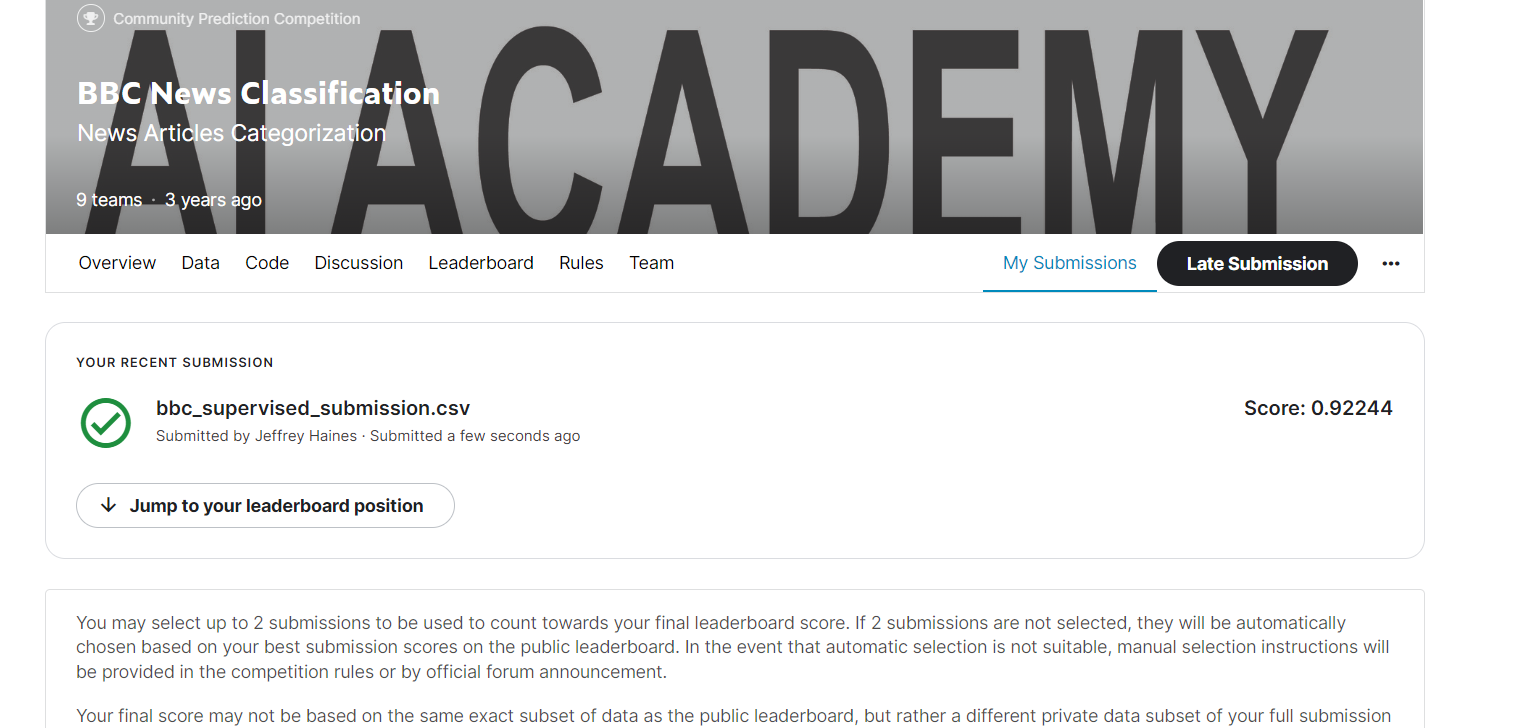